# XGBoost Final Training and Evaluation

This notebook trains XGBoost with the best hyperparameters found during tuning and evaluates on the test set.

**Task**: Multiclass fault classification (18 classes)

**Data Split**:
- Train: Model fitting
- Validation: Early stopping monitoring
- Test: Final evaluation (never seen during training)

**Modes**:
- QUICK_MODE: Uses 1% of training data with tuned hyperparameters (early stopping limits actual trees)
- FULL MODE: Uses all training data with tuned hyperparameters

**Outputs**:
- Trained model: `outputs/models/xgboost_final[_quick].pkl`
- Metrics: `outputs/metrics/xgboost_metrics[_quick].json`
- Confusion matrix: `outputs/figures/xgboost_confusion_matrix[_quick].png`

## Configuration

In [1]:
import os
import sys
import time
import json
import pickle
from pathlib import Path

start_time = time.time()

# Quick mode configuration
QUICK_MODE = os.getenv('QUICK_MODE', 'False').lower() in ('true', '1', 'yes')

# Paths
DATA_DIR = Path('../data')
OUTPUT_DIR = Path('../outputs')
HYPERPARAM_DIR = OUTPUT_DIR / 'hyperparams'
MODEL_DIR = OUTPUT_DIR / 'models'
METRICS_DIR = OUTPUT_DIR / 'metrics'
FIGURES_DIR = OUTPUT_DIR / 'figures'

# Create output directories
MODEL_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_SEED = 42
MODE_SUFFIX = '_quick' if QUICK_MODE else ''

# Setup progress logging
LOG_FILE = OUTPUT_DIR / f'xgboost_final_progress{MODE_SUFFIX}.log'

def log(msg):
    """Log message to both stdout and file."""
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S')
    full_msg = f"[{timestamp}] {msg}"
    print(full_msg)
    with open(LOG_FILE, 'a') as f:
        f.write(full_msg + '\n')

# Clear log file at start
with open(LOG_FILE, 'w') as f:
    f.write('')

log("="*60)
log("XGBoost Final Training and Evaluation")
log("="*60)

if QUICK_MODE:
    TRAIN_FRACTION = 0.01
    EARLY_STOPPING_ROUNDS = 10
    log("🚀 QUICK MODE (1% data, tuned hyperparameters)")
else:
    TRAIN_FRACTION = 1.0
    EARLY_STOPPING_ROUNDS = 50
    log("🔬 FULL MODE (100% data, tuned hyperparameters)")

# Load best hyperparameters (prefer full mode, fall back to quick)
if (HYPERPARAM_DIR / 'xgboost_best.json').exists():
    hp_file = HYPERPARAM_DIR / 'xgboost_best.json'
    log("Using FULL mode hyperparameters")
else:
    hp_file = HYPERPARAM_DIR / 'xgboost_best_quick.json'
    log("Using QUICK mode hyperparameters")

with open(hp_file) as f:
    hp_data = json.load(f)
    best_params = hp_data['best_params']

log(f"Hyperparameters: {best_params}")
log("="*60)

[2026-01-05 14:22:46] ============================================================
[2026-01-05 14:22:46] XGBoost Final Training and Evaluation
[2026-01-05 14:22:46] ============================================================
[2026-01-05 14:22:46] 🔬 FULL MODE (100% data, tuned hyperparameters)
[2026-01-05 14:22:46] Using FULL mode hyperparameters
[2026-01-05 14:22:46] Hyperparameters: {'n_estimators': 499, 'max_depth': 6, 'learning_rate': 0.19577281917580747, 'subsample': 0.9669001079522812, 'colsample_bytree': 0.8412714911551206, 'min_child_weight': 8, 'gamma': 0.5635598310188895, 'reg_alpha': 0.3293109960325205, 'reg_lambda': 0.06309550078956783}
[2026-01-05 14:22:46] ============================================================


## Imports

In [2]:
log("[Step 1/5] Loading libraries...")
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, balanced_accuracy_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

log("✓ Imports successful")

[2026-01-05 14:22:46] [Step 1/5] Loading libraries...


[2026-01-05 14:22:48] ✓ Imports successful


## Data Loading

In [3]:
log("[Step 2/5] Loading datasets...")
data_load_start = time.time()

train = pd.read_csv(DATA_DIR / 'multiclass_train.csv')
val = pd.read_csv(DATA_DIR / 'multiclass_val.csv')
test = pd.read_csv(DATA_DIR / 'multiclass_test.csv')

log(f"✓ Train: {train.shape}")
log(f"✓ Val: {val.shape}")
log(f"✓ Test: {test.shape}")
log(f"✓ Data loading time: {time.time() - data_load_start:.2f}s")

[2026-01-05 14:22:48] [Step 2/5] Loading datasets...


[2026-01-05 14:23:03] ✓ Train: (864000, 57)
[2026-01-05 14:23:03] ✓ Val: (432000, 57)
[2026-01-05 14:23:03] ✓ Test: (2880000, 57)
[2026-01-05 14:23:03] ✓ Data loading time: 14.77s


In [4]:
log("[Step 3/5] Preparing features and labels...")

# Extract features
features = [col for col in train.columns if 'xmeas' in col or 'xmv' in col]
log(f"✓ Number of features: {len(features)}")

# Subsample training data if in quick mode
if TRAIN_FRACTION < 1.0:
    train = train.sample(frac=TRAIN_FRACTION, random_state=RANDOM_SEED)
    val = val.sample(frac=TRAIN_FRACTION, random_state=RANDOM_SEED)
    log(f"✓ Subsampled train to {TRAIN_FRACTION*100:.1f}%: {train.shape}")
    log(f"✓ Subsampled val to {TRAIN_FRACTION*100:.1f}%: {val.shape}")

X_train = train[features].values
y_train = train['faultNumber'].values
X_val = val[features].values
y_val = val['faultNumber'].values
X_test = test[features].values
y_test = test['faultNumber'].values

# Standardize features (fit on train only)
log("✓ Standardizing features (fit on train only)...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Encode labels (fit on train only)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)
class_names = [str(int(c)) for c in label_encoder.classes_]
log(f"✓ Number of classes: {num_classes}")

[2026-01-05 14:23:03] [Step 3/5] Preparing features and labels...
[2026-01-05 14:23:03] ✓ Number of features: 52


[2026-01-05 14:23:03] ✓ Standardizing features (fit on train only)...


[2026-01-05 14:23:04] ✓ Number of classes: 18


## Model Training

In [5]:
log("[Step 4/5] Training model with early stopping on validation set...")
train_start = time.time()

# Build model with best hyperparameters
model = XGBClassifier(
    **best_params,
    random_state=RANDOM_SEED,
    eval_metric='mlogloss',
    tree_method='hist',
    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    n_jobs=-1
)

# Train with early stopping on validation set
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)

train_time = time.time() - train_start
best_iteration = model.best_iteration
log(f"✓ Training complete in {train_time:.2f}s")
log(f"✓ Best iteration: {best_iteration}")

[2026-01-05 14:23:04] [Step 4/5] Training model with early stopping on validation set...


[0]	validation_0-mlogloss:1.95208	validation_1-mlogloss:1.95217


[1]	validation_0-mlogloss:1.65629	validation_1-mlogloss:1.65895


[2]	validation_0-mlogloss:1.45558	validation_1-mlogloss:1.45907


[3]	validation_0-mlogloss:1.31204	validation_1-mlogloss:1.31643


[4]	validation_0-mlogloss:1.19387	validation_1-mlogloss:1.19917


[5]	validation_0-mlogloss:1.09151	validation_1-mlogloss:1.09755


[6]	validation_0-mlogloss:1.01063	validation_1-mlogloss:1.01751


[7]	validation_0-mlogloss:0.94295	validation_1-mlogloss:0.95053


[8]	validation_0-mlogloss:0.88168	validation_1-mlogloss:0.88972


[9]	validation_0-mlogloss:0.83370	validation_1-mlogloss:0.84199


[10]	validation_0-mlogloss:0.78605	validation_1-mlogloss:0.79488


[11]	validation_0-mlogloss:0.74967	validation_1-mlogloss:0.75896


[12]	validation_0-mlogloss:0.71546	validation_1-mlogloss:0.72502


[13]	validation_0-mlogloss:0.68782	validation_1-mlogloss:0.69766


[14]	validation_0-mlogloss:0.66424	validation_1-mlogloss:0.67426


[15]	validation_0-mlogloss:0.63963	validation_1-mlogloss:0.65002


[16]	validation_0-mlogloss:0.61779	validation_1-mlogloss:0.62843


[17]	validation_0-mlogloss:0.60019	validation_1-mlogloss:0.61126


[18]	validation_0-mlogloss:0.58402	validation_1-mlogloss:0.59547


[19]	validation_0-mlogloss:0.56719	validation_1-mlogloss:0.57891


[20]	validation_0-mlogloss:0.54863	validation_1-mlogloss:0.56088


[21]	validation_0-mlogloss:0.53262	validation_1-mlogloss:0.54523


[22]	validation_0-mlogloss:0.51771	validation_1-mlogloss:0.53062


[23]	validation_0-mlogloss:0.50268	validation_1-mlogloss:0.51600


[24]	validation_0-mlogloss:0.48769	validation_1-mlogloss:0.50126


[25]	validation_0-mlogloss:0.47559	validation_1-mlogloss:0.48935


[26]	validation_0-mlogloss:0.46514	validation_1-mlogloss:0.47911


[27]	validation_0-mlogloss:0.45725	validation_1-mlogloss:0.47147


[28]	validation_0-mlogloss:0.44725	validation_1-mlogloss:0.46169


[29]	validation_0-mlogloss:0.44057	validation_1-mlogloss:0.45518


[30]	validation_0-mlogloss:0.43269	validation_1-mlogloss:0.44748


[31]	validation_0-mlogloss:0.42584	validation_1-mlogloss:0.44089


[32]	validation_0-mlogloss:0.41850	validation_1-mlogloss:0.43381


[33]	validation_0-mlogloss:0.41138	validation_1-mlogloss:0.42679


[34]	validation_0-mlogloss:0.40384	validation_1-mlogloss:0.41959


[35]	validation_0-mlogloss:0.39899	validation_1-mlogloss:0.41494


[36]	validation_0-mlogloss:0.39410	validation_1-mlogloss:0.41029


[37]	validation_0-mlogloss:0.38999	validation_1-mlogloss:0.40637


[38]	validation_0-mlogloss:0.38614	validation_1-mlogloss:0.40282


[39]	validation_0-mlogloss:0.38044	validation_1-mlogloss:0.39748


[40]	validation_0-mlogloss:0.37674	validation_1-mlogloss:0.39404


[41]	validation_0-mlogloss:0.37241	validation_1-mlogloss:0.39000


[42]	validation_0-mlogloss:0.36820	validation_1-mlogloss:0.38599


[43]	validation_0-mlogloss:0.36528	validation_1-mlogloss:0.38331


[44]	validation_0-mlogloss:0.36179	validation_1-mlogloss:0.38015


[45]	validation_0-mlogloss:0.35920	validation_1-mlogloss:0.37777


[46]	validation_0-mlogloss:0.35653	validation_1-mlogloss:0.37528


[47]	validation_0-mlogloss:0.35436	validation_1-mlogloss:0.37345


[48]	validation_0-mlogloss:0.35173	validation_1-mlogloss:0.37106


[49]	validation_0-mlogloss:0.34779	validation_1-mlogloss:0.36735


[50]	validation_0-mlogloss:0.34490	validation_1-mlogloss:0.36479


[51]	validation_0-mlogloss:0.34088	validation_1-mlogloss:0.36103


[52]	validation_0-mlogloss:0.33829	validation_1-mlogloss:0.35867


[53]	validation_0-mlogloss:0.33615	validation_1-mlogloss:0.35672


[54]	validation_0-mlogloss:0.33360	validation_1-mlogloss:0.35442


[55]	validation_0-mlogloss:0.33133	validation_1-mlogloss:0.35232


[56]	validation_0-mlogloss:0.32877	validation_1-mlogloss:0.34988


[57]	validation_0-mlogloss:0.32722	validation_1-mlogloss:0.34858


[58]	validation_0-mlogloss:0.32580	validation_1-mlogloss:0.34746


[59]	validation_0-mlogloss:0.32362	validation_1-mlogloss:0.34557


[60]	validation_0-mlogloss:0.32188	validation_1-mlogloss:0.34419


[61]	validation_0-mlogloss:0.32042	validation_1-mlogloss:0.34297


[62]	validation_0-mlogloss:0.31874	validation_1-mlogloss:0.34154


[63]	validation_0-mlogloss:0.31719	validation_1-mlogloss:0.34020


[64]	validation_0-mlogloss:0.31585	validation_1-mlogloss:0.33918


[65]	validation_0-mlogloss:0.31466	validation_1-mlogloss:0.33824


[66]	validation_0-mlogloss:0.31117	validation_1-mlogloss:0.33498


[67]	validation_0-mlogloss:0.30854	validation_1-mlogloss:0.33263


[68]	validation_0-mlogloss:0.30631	validation_1-mlogloss:0.33067


[69]	validation_0-mlogloss:0.30398	validation_1-mlogloss:0.32873


[70]	validation_0-mlogloss:0.30277	validation_1-mlogloss:0.32784


[71]	validation_0-mlogloss:0.30169	validation_1-mlogloss:0.32701


[72]	validation_0-mlogloss:0.29979	validation_1-mlogloss:0.32543


[73]	validation_0-mlogloss:0.29683	validation_1-mlogloss:0.32279


[74]	validation_0-mlogloss:0.29545	validation_1-mlogloss:0.32161


[75]	validation_0-mlogloss:0.29358	validation_1-mlogloss:0.32009


[76]	validation_0-mlogloss:0.29232	validation_1-mlogloss:0.31908


[77]	validation_0-mlogloss:0.29132	validation_1-mlogloss:0.31831


[78]	validation_0-mlogloss:0.28971	validation_1-mlogloss:0.31698


[79]	validation_0-mlogloss:0.28855	validation_1-mlogloss:0.31617


[80]	validation_0-mlogloss:0.28768	validation_1-mlogloss:0.31555


[81]	validation_0-mlogloss:0.28652	validation_1-mlogloss:0.31471


[82]	validation_0-mlogloss:0.28478	validation_1-mlogloss:0.31340


[83]	validation_0-mlogloss:0.28388	validation_1-mlogloss:0.31278


[84]	validation_0-mlogloss:0.28302	validation_1-mlogloss:0.31216


[85]	validation_0-mlogloss:0.28183	validation_1-mlogloss:0.31121


[86]	validation_0-mlogloss:0.28012	validation_1-mlogloss:0.30971


[87]	validation_0-mlogloss:0.27897	validation_1-mlogloss:0.30885


[88]	validation_0-mlogloss:0.27747	validation_1-mlogloss:0.30770


[89]	validation_0-mlogloss:0.27629	validation_1-mlogloss:0.30684


[90]	validation_0-mlogloss:0.27505	validation_1-mlogloss:0.30591


[91]	validation_0-mlogloss:0.27426	validation_1-mlogloss:0.30537


[92]	validation_0-mlogloss:0.27357	validation_1-mlogloss:0.30494


[93]	validation_0-mlogloss:0.27241	validation_1-mlogloss:0.30408


[94]	validation_0-mlogloss:0.27089	validation_1-mlogloss:0.30289


[95]	validation_0-mlogloss:0.27012	validation_1-mlogloss:0.30253


[96]	validation_0-mlogloss:0.26854	validation_1-mlogloss:0.30122


[97]	validation_0-mlogloss:0.26740	validation_1-mlogloss:0.30045


[98]	validation_0-mlogloss:0.26639	validation_1-mlogloss:0.29971


[99]	validation_0-mlogloss:0.26535	validation_1-mlogloss:0.29903


[100]	validation_0-mlogloss:0.26445	validation_1-mlogloss:0.29848


[101]	validation_0-mlogloss:0.26342	validation_1-mlogloss:0.29769


[102]	validation_0-mlogloss:0.26253	validation_1-mlogloss:0.29712


[103]	validation_0-mlogloss:0.26185	validation_1-mlogloss:0.29675


[104]	validation_0-mlogloss:0.26088	validation_1-mlogloss:0.29617


[105]	validation_0-mlogloss:0.25964	validation_1-mlogloss:0.29535


[106]	validation_0-mlogloss:0.25877	validation_1-mlogloss:0.29485


[107]	validation_0-mlogloss:0.25783	validation_1-mlogloss:0.29421


[108]	validation_0-mlogloss:0.25663	validation_1-mlogloss:0.29323


[109]	validation_0-mlogloss:0.25596	validation_1-mlogloss:0.29297


[110]	validation_0-mlogloss:0.25519	validation_1-mlogloss:0.29244


[111]	validation_0-mlogloss:0.25434	validation_1-mlogloss:0.29188


[112]	validation_0-mlogloss:0.25363	validation_1-mlogloss:0.29158


[113]	validation_0-mlogloss:0.25285	validation_1-mlogloss:0.29114


[114]	validation_0-mlogloss:0.25189	validation_1-mlogloss:0.29057


[115]	validation_0-mlogloss:0.25132	validation_1-mlogloss:0.29036


[116]	validation_0-mlogloss:0.25053	validation_1-mlogloss:0.28993


[117]	validation_0-mlogloss:0.24986	validation_1-mlogloss:0.28951


[118]	validation_0-mlogloss:0.24913	validation_1-mlogloss:0.28905


[119]	validation_0-mlogloss:0.24845	validation_1-mlogloss:0.28869


[120]	validation_0-mlogloss:0.24746	validation_1-mlogloss:0.28817


[121]	validation_0-mlogloss:0.24704	validation_1-mlogloss:0.28794


[122]	validation_0-mlogloss:0.24533	validation_1-mlogloss:0.28657


[123]	validation_0-mlogloss:0.24462	validation_1-mlogloss:0.28624


[124]	validation_0-mlogloss:0.24365	validation_1-mlogloss:0.28559


[125]	validation_0-mlogloss:0.24271	validation_1-mlogloss:0.28504


[126]	validation_0-mlogloss:0.24210	validation_1-mlogloss:0.28475


[127]	validation_0-mlogloss:0.24146	validation_1-mlogloss:0.28431


[128]	validation_0-mlogloss:0.24109	validation_1-mlogloss:0.28417


[129]	validation_0-mlogloss:0.24035	validation_1-mlogloss:0.28375


[130]	validation_0-mlogloss:0.23977	validation_1-mlogloss:0.28340


[131]	validation_0-mlogloss:0.23909	validation_1-mlogloss:0.28314


[132]	validation_0-mlogloss:0.23825	validation_1-mlogloss:0.28261


[133]	validation_0-mlogloss:0.23780	validation_1-mlogloss:0.28239


[134]	validation_0-mlogloss:0.23713	validation_1-mlogloss:0.28205


[135]	validation_0-mlogloss:0.23652	validation_1-mlogloss:0.28188


[136]	validation_0-mlogloss:0.23590	validation_1-mlogloss:0.28156


[137]	validation_0-mlogloss:0.23507	validation_1-mlogloss:0.28091


[138]	validation_0-mlogloss:0.23435	validation_1-mlogloss:0.28040


[139]	validation_0-mlogloss:0.23371	validation_1-mlogloss:0.28008


[140]	validation_0-mlogloss:0.23298	validation_1-mlogloss:0.27971


[141]	validation_0-mlogloss:0.23232	validation_1-mlogloss:0.27928


[142]	validation_0-mlogloss:0.23178	validation_1-mlogloss:0.27903


[143]	validation_0-mlogloss:0.23121	validation_1-mlogloss:0.27875


[144]	validation_0-mlogloss:0.23008	validation_1-mlogloss:0.27790


[145]	validation_0-mlogloss:0.22949	validation_1-mlogloss:0.27768


[146]	validation_0-mlogloss:0.22893	validation_1-mlogloss:0.27739


[147]	validation_0-mlogloss:0.22836	validation_1-mlogloss:0.27714


[148]	validation_0-mlogloss:0.22741	validation_1-mlogloss:0.27639


[149]	validation_0-mlogloss:0.22683	validation_1-mlogloss:0.27606


[150]	validation_0-mlogloss:0.22606	validation_1-mlogloss:0.27563


[151]	validation_0-mlogloss:0.22549	validation_1-mlogloss:0.27532


[152]	validation_0-mlogloss:0.22472	validation_1-mlogloss:0.27494


[153]	validation_0-mlogloss:0.22421	validation_1-mlogloss:0.27466


[154]	validation_0-mlogloss:0.22357	validation_1-mlogloss:0.27440


[155]	validation_0-mlogloss:0.22316	validation_1-mlogloss:0.27419


[156]	validation_0-mlogloss:0.22237	validation_1-mlogloss:0.27370


[157]	validation_0-mlogloss:0.22160	validation_1-mlogloss:0.27319


[158]	validation_0-mlogloss:0.22114	validation_1-mlogloss:0.27307


[159]	validation_0-mlogloss:0.22048	validation_1-mlogloss:0.27269


[160]	validation_0-mlogloss:0.22001	validation_1-mlogloss:0.27242


[161]	validation_0-mlogloss:0.21917	validation_1-mlogloss:0.27187


[162]	validation_0-mlogloss:0.21846	validation_1-mlogloss:0.27143


[163]	validation_0-mlogloss:0.21795	validation_1-mlogloss:0.27128


[164]	validation_0-mlogloss:0.21717	validation_1-mlogloss:0.27091


[165]	validation_0-mlogloss:0.21652	validation_1-mlogloss:0.27047


[166]	validation_0-mlogloss:0.21607	validation_1-mlogloss:0.27029


[167]	validation_0-mlogloss:0.21549	validation_1-mlogloss:0.26997


[168]	validation_0-mlogloss:0.21490	validation_1-mlogloss:0.26952


[169]	validation_0-mlogloss:0.21349	validation_1-mlogloss:0.26849


[170]	validation_0-mlogloss:0.21294	validation_1-mlogloss:0.26838


[171]	validation_0-mlogloss:0.21235	validation_1-mlogloss:0.26817


[172]	validation_0-mlogloss:0.21173	validation_1-mlogloss:0.26787


[173]	validation_0-mlogloss:0.21043	validation_1-mlogloss:0.26688


[174]	validation_0-mlogloss:0.20987	validation_1-mlogloss:0.26657


[175]	validation_0-mlogloss:0.20931	validation_1-mlogloss:0.26634


[176]	validation_0-mlogloss:0.20857	validation_1-mlogloss:0.26612


[177]	validation_0-mlogloss:0.20794	validation_1-mlogloss:0.26587


[178]	validation_0-mlogloss:0.20745	validation_1-mlogloss:0.26577


[179]	validation_0-mlogloss:0.20669	validation_1-mlogloss:0.26538


[180]	validation_0-mlogloss:0.20619	validation_1-mlogloss:0.26518


[181]	validation_0-mlogloss:0.20568	validation_1-mlogloss:0.26502


[182]	validation_0-mlogloss:0.20525	validation_1-mlogloss:0.26489


[183]	validation_0-mlogloss:0.20472	validation_1-mlogloss:0.26464


[184]	validation_0-mlogloss:0.20407	validation_1-mlogloss:0.26427


[185]	validation_0-mlogloss:0.20364	validation_1-mlogloss:0.26407


[186]	validation_0-mlogloss:0.20315	validation_1-mlogloss:0.26385


[187]	validation_0-mlogloss:0.20271	validation_1-mlogloss:0.26378


[188]	validation_0-mlogloss:0.20230	validation_1-mlogloss:0.26360


[189]	validation_0-mlogloss:0.20192	validation_1-mlogloss:0.26350


[190]	validation_0-mlogloss:0.20157	validation_1-mlogloss:0.26342


[191]	validation_0-mlogloss:0.20111	validation_1-mlogloss:0.26329


[192]	validation_0-mlogloss:0.20050	validation_1-mlogloss:0.26297


[193]	validation_0-mlogloss:0.19985	validation_1-mlogloss:0.26259


[194]	validation_0-mlogloss:0.19923	validation_1-mlogloss:0.26221


[195]	validation_0-mlogloss:0.19862	validation_1-mlogloss:0.26178


[196]	validation_0-mlogloss:0.19832	validation_1-mlogloss:0.26174


[197]	validation_0-mlogloss:0.19784	validation_1-mlogloss:0.26160


[198]	validation_0-mlogloss:0.19745	validation_1-mlogloss:0.26146


[199]	validation_0-mlogloss:0.19699	validation_1-mlogloss:0.26124


[200]	validation_0-mlogloss:0.19654	validation_1-mlogloss:0.26109


[201]	validation_0-mlogloss:0.19617	validation_1-mlogloss:0.26099


[202]	validation_0-mlogloss:0.19579	validation_1-mlogloss:0.26092


[203]	validation_0-mlogloss:0.19541	validation_1-mlogloss:0.26087


[204]	validation_0-mlogloss:0.19498	validation_1-mlogloss:0.26068


[205]	validation_0-mlogloss:0.19457	validation_1-mlogloss:0.26060


[206]	validation_0-mlogloss:0.19422	validation_1-mlogloss:0.26052


[207]	validation_0-mlogloss:0.19363	validation_1-mlogloss:0.26026


[208]	validation_0-mlogloss:0.19301	validation_1-mlogloss:0.25993


[209]	validation_0-mlogloss:0.19234	validation_1-mlogloss:0.25958


[210]	validation_0-mlogloss:0.19184	validation_1-mlogloss:0.25938


[211]	validation_0-mlogloss:0.19148	validation_1-mlogloss:0.25928


[212]	validation_0-mlogloss:0.19110	validation_1-mlogloss:0.25923


[213]	validation_0-mlogloss:0.19068	validation_1-mlogloss:0.25906


[214]	validation_0-mlogloss:0.19031	validation_1-mlogloss:0.25891


[215]	validation_0-mlogloss:0.18980	validation_1-mlogloss:0.25867


[216]	validation_0-mlogloss:0.18932	validation_1-mlogloss:0.25850


[217]	validation_0-mlogloss:0.18898	validation_1-mlogloss:0.25836


[218]	validation_0-mlogloss:0.18838	validation_1-mlogloss:0.25803


[219]	validation_0-mlogloss:0.18791	validation_1-mlogloss:0.25793


[220]	validation_0-mlogloss:0.18735	validation_1-mlogloss:0.25766


[221]	validation_0-mlogloss:0.18692	validation_1-mlogloss:0.25753


[222]	validation_0-mlogloss:0.18650	validation_1-mlogloss:0.25741


[223]	validation_0-mlogloss:0.18606	validation_1-mlogloss:0.25721


[224]	validation_0-mlogloss:0.18563	validation_1-mlogloss:0.25710


[225]	validation_0-mlogloss:0.18513	validation_1-mlogloss:0.25684


[226]	validation_0-mlogloss:0.18469	validation_1-mlogloss:0.25672


[227]	validation_0-mlogloss:0.18419	validation_1-mlogloss:0.25654


[228]	validation_0-mlogloss:0.18373	validation_1-mlogloss:0.25643


[229]	validation_0-mlogloss:0.18326	validation_1-mlogloss:0.25626


[230]	validation_0-mlogloss:0.18238	validation_1-mlogloss:0.25566


[231]	validation_0-mlogloss:0.18194	validation_1-mlogloss:0.25555


[232]	validation_0-mlogloss:0.18147	validation_1-mlogloss:0.25538


[233]	validation_0-mlogloss:0.18095	validation_1-mlogloss:0.25526


[234]	validation_0-mlogloss:0.18042	validation_1-mlogloss:0.25496


[235]	validation_0-mlogloss:0.17997	validation_1-mlogloss:0.25486


[236]	validation_0-mlogloss:0.17967	validation_1-mlogloss:0.25487


[237]	validation_0-mlogloss:0.17921	validation_1-mlogloss:0.25463


[238]	validation_0-mlogloss:0.17882	validation_1-mlogloss:0.25452


[239]	validation_0-mlogloss:0.17855	validation_1-mlogloss:0.25444


[240]	validation_0-mlogloss:0.17824	validation_1-mlogloss:0.25432


[241]	validation_0-mlogloss:0.17779	validation_1-mlogloss:0.25421


[242]	validation_0-mlogloss:0.17741	validation_1-mlogloss:0.25410


[243]	validation_0-mlogloss:0.17711	validation_1-mlogloss:0.25401


[244]	validation_0-mlogloss:0.17663	validation_1-mlogloss:0.25387


[245]	validation_0-mlogloss:0.17622	validation_1-mlogloss:0.25382


[246]	validation_0-mlogloss:0.17593	validation_1-mlogloss:0.25376


[247]	validation_0-mlogloss:0.17552	validation_1-mlogloss:0.25361


[248]	validation_0-mlogloss:0.17523	validation_1-mlogloss:0.25354


[249]	validation_0-mlogloss:0.17482	validation_1-mlogloss:0.25343


[250]	validation_0-mlogloss:0.17445	validation_1-mlogloss:0.25334


[251]	validation_0-mlogloss:0.17407	validation_1-mlogloss:0.25322


[252]	validation_0-mlogloss:0.17372	validation_1-mlogloss:0.25323


[253]	validation_0-mlogloss:0.17324	validation_1-mlogloss:0.25305


[254]	validation_0-mlogloss:0.17287	validation_1-mlogloss:0.25297


[255]	validation_0-mlogloss:0.17249	validation_1-mlogloss:0.25289


[256]	validation_0-mlogloss:0.17209	validation_1-mlogloss:0.25280


[257]	validation_0-mlogloss:0.17169	validation_1-mlogloss:0.25268


[258]	validation_0-mlogloss:0.17128	validation_1-mlogloss:0.25259


[259]	validation_0-mlogloss:0.17069	validation_1-mlogloss:0.25224


[260]	validation_0-mlogloss:0.17031	validation_1-mlogloss:0.25218


[261]	validation_0-mlogloss:0.16998	validation_1-mlogloss:0.25210


[262]	validation_0-mlogloss:0.16964	validation_1-mlogloss:0.25204


[263]	validation_0-mlogloss:0.16905	validation_1-mlogloss:0.25168


[264]	validation_0-mlogloss:0.16884	validation_1-mlogloss:0.25162


[265]	validation_0-mlogloss:0.16829	validation_1-mlogloss:0.25136


[266]	validation_0-mlogloss:0.16791	validation_1-mlogloss:0.25130


[267]	validation_0-mlogloss:0.16761	validation_1-mlogloss:0.25125


[268]	validation_0-mlogloss:0.16720	validation_1-mlogloss:0.25113


[269]	validation_0-mlogloss:0.16689	validation_1-mlogloss:0.25104


[270]	validation_0-mlogloss:0.16644	validation_1-mlogloss:0.25086


[271]	validation_0-mlogloss:0.16606	validation_1-mlogloss:0.25071


[272]	validation_0-mlogloss:0.16567	validation_1-mlogloss:0.25061


[273]	validation_0-mlogloss:0.16524	validation_1-mlogloss:0.25055


[274]	validation_0-mlogloss:0.16488	validation_1-mlogloss:0.25053


[275]	validation_0-mlogloss:0.16438	validation_1-mlogloss:0.25026


[276]	validation_0-mlogloss:0.16393	validation_1-mlogloss:0.25012


[277]	validation_0-mlogloss:0.16346	validation_1-mlogloss:0.24990


[278]	validation_0-mlogloss:0.16311	validation_1-mlogloss:0.24988


[279]	validation_0-mlogloss:0.16257	validation_1-mlogloss:0.24961


[280]	validation_0-mlogloss:0.16218	validation_1-mlogloss:0.24959


[281]	validation_0-mlogloss:0.16187	validation_1-mlogloss:0.24950


[282]	validation_0-mlogloss:0.16154	validation_1-mlogloss:0.24946


[283]	validation_0-mlogloss:0.16123	validation_1-mlogloss:0.24943


[284]	validation_0-mlogloss:0.16078	validation_1-mlogloss:0.24929


[285]	validation_0-mlogloss:0.16056	validation_1-mlogloss:0.24926


[286]	validation_0-mlogloss:0.16027	validation_1-mlogloss:0.24919


[287]	validation_0-mlogloss:0.15997	validation_1-mlogloss:0.24921


[288]	validation_0-mlogloss:0.15969	validation_1-mlogloss:0.24915


[289]	validation_0-mlogloss:0.15924	validation_1-mlogloss:0.24900


[290]	validation_0-mlogloss:0.15896	validation_1-mlogloss:0.24896


[291]	validation_0-mlogloss:0.15859	validation_1-mlogloss:0.24890


[292]	validation_0-mlogloss:0.15820	validation_1-mlogloss:0.24881


[293]	validation_0-mlogloss:0.15785	validation_1-mlogloss:0.24868


[294]	validation_0-mlogloss:0.15745	validation_1-mlogloss:0.24868


[295]	validation_0-mlogloss:0.15703	validation_1-mlogloss:0.24851


[296]	validation_0-mlogloss:0.15672	validation_1-mlogloss:0.24850


[297]	validation_0-mlogloss:0.15621	validation_1-mlogloss:0.24829


[298]	validation_0-mlogloss:0.15592	validation_1-mlogloss:0.24822


[299]	validation_0-mlogloss:0.15565	validation_1-mlogloss:0.24813


[300]	validation_0-mlogloss:0.15536	validation_1-mlogloss:0.24811


[301]	validation_0-mlogloss:0.15511	validation_1-mlogloss:0.24804


[302]	validation_0-mlogloss:0.15479	validation_1-mlogloss:0.24803


[303]	validation_0-mlogloss:0.15453	validation_1-mlogloss:0.24803


[304]	validation_0-mlogloss:0.15419	validation_1-mlogloss:0.24802


[305]	validation_0-mlogloss:0.15381	validation_1-mlogloss:0.24785


[306]	validation_0-mlogloss:0.15356	validation_1-mlogloss:0.24788


[307]	validation_0-mlogloss:0.15325	validation_1-mlogloss:0.24781


[308]	validation_0-mlogloss:0.15297	validation_1-mlogloss:0.24783


[309]	validation_0-mlogloss:0.15280	validation_1-mlogloss:0.24777


[310]	validation_0-mlogloss:0.15252	validation_1-mlogloss:0.24773


[311]	validation_0-mlogloss:0.15217	validation_1-mlogloss:0.24774


[312]	validation_0-mlogloss:0.15190	validation_1-mlogloss:0.24773


[313]	validation_0-mlogloss:0.15156	validation_1-mlogloss:0.24766


[314]	validation_0-mlogloss:0.15123	validation_1-mlogloss:0.24767


[315]	validation_0-mlogloss:0.15085	validation_1-mlogloss:0.24764


[316]	validation_0-mlogloss:0.15057	validation_1-mlogloss:0.24758


[317]	validation_0-mlogloss:0.15029	validation_1-mlogloss:0.24751


[318]	validation_0-mlogloss:0.15007	validation_1-mlogloss:0.24747


[319]	validation_0-mlogloss:0.14968	validation_1-mlogloss:0.24730


[320]	validation_0-mlogloss:0.14938	validation_1-mlogloss:0.24732


[321]	validation_0-mlogloss:0.14910	validation_1-mlogloss:0.24721


[322]	validation_0-mlogloss:0.14888	validation_1-mlogloss:0.24713


[323]	validation_0-mlogloss:0.14859	validation_1-mlogloss:0.24707


[324]	validation_0-mlogloss:0.14825	validation_1-mlogloss:0.24706


[325]	validation_0-mlogloss:0.14790	validation_1-mlogloss:0.24703


[326]	validation_0-mlogloss:0.14767	validation_1-mlogloss:0.24699


[327]	validation_0-mlogloss:0.14732	validation_1-mlogloss:0.24689


[328]	validation_0-mlogloss:0.14705	validation_1-mlogloss:0.24685


[329]	validation_0-mlogloss:0.14675	validation_1-mlogloss:0.24685


[330]	validation_0-mlogloss:0.14645	validation_1-mlogloss:0.24681


[331]	validation_0-mlogloss:0.14615	validation_1-mlogloss:0.24675


[332]	validation_0-mlogloss:0.14589	validation_1-mlogloss:0.24667


[333]	validation_0-mlogloss:0.14569	validation_1-mlogloss:0.24668


[334]	validation_0-mlogloss:0.14545	validation_1-mlogloss:0.24664


[335]	validation_0-mlogloss:0.14519	validation_1-mlogloss:0.24662


[336]	validation_0-mlogloss:0.14491	validation_1-mlogloss:0.24660


[337]	validation_0-mlogloss:0.14453	validation_1-mlogloss:0.24655


[338]	validation_0-mlogloss:0.14429	validation_1-mlogloss:0.24655


[339]	validation_0-mlogloss:0.14404	validation_1-mlogloss:0.24650


[340]	validation_0-mlogloss:0.14375	validation_1-mlogloss:0.24647


[341]	validation_0-mlogloss:0.14347	validation_1-mlogloss:0.24644


[342]	validation_0-mlogloss:0.14323	validation_1-mlogloss:0.24640


[343]	validation_0-mlogloss:0.14296	validation_1-mlogloss:0.24629


[344]	validation_0-mlogloss:0.14269	validation_1-mlogloss:0.24630


[345]	validation_0-mlogloss:0.14231	validation_1-mlogloss:0.24624


[346]	validation_0-mlogloss:0.14209	validation_1-mlogloss:0.24618


[347]	validation_0-mlogloss:0.14183	validation_1-mlogloss:0.24615


[348]	validation_0-mlogloss:0.14153	validation_1-mlogloss:0.24613


[349]	validation_0-mlogloss:0.14129	validation_1-mlogloss:0.24611


[350]	validation_0-mlogloss:0.14108	validation_1-mlogloss:0.24609


[351]	validation_0-mlogloss:0.14077	validation_1-mlogloss:0.24603


[352]	validation_0-mlogloss:0.14050	validation_1-mlogloss:0.24598


[353]	validation_0-mlogloss:0.14028	validation_1-mlogloss:0.24596


[354]	validation_0-mlogloss:0.14004	validation_1-mlogloss:0.24590


[355]	validation_0-mlogloss:0.13980	validation_1-mlogloss:0.24591


[356]	validation_0-mlogloss:0.13949	validation_1-mlogloss:0.24586


[357]	validation_0-mlogloss:0.13917	validation_1-mlogloss:0.24586


[358]	validation_0-mlogloss:0.13889	validation_1-mlogloss:0.24577


[359]	validation_0-mlogloss:0.13867	validation_1-mlogloss:0.24570


[360]	validation_0-mlogloss:0.13841	validation_1-mlogloss:0.24564


[361]	validation_0-mlogloss:0.13824	validation_1-mlogloss:0.24566


[362]	validation_0-mlogloss:0.13799	validation_1-mlogloss:0.24562


[363]	validation_0-mlogloss:0.13774	validation_1-mlogloss:0.24559


[364]	validation_0-mlogloss:0.13753	validation_1-mlogloss:0.24558


[365]	validation_0-mlogloss:0.13724	validation_1-mlogloss:0.24545


[366]	validation_0-mlogloss:0.13703	validation_1-mlogloss:0.24546


[367]	validation_0-mlogloss:0.13684	validation_1-mlogloss:0.24545


[368]	validation_0-mlogloss:0.13658	validation_1-mlogloss:0.24548


[369]	validation_0-mlogloss:0.13642	validation_1-mlogloss:0.24548


[370]	validation_0-mlogloss:0.13622	validation_1-mlogloss:0.24549


[371]	validation_0-mlogloss:0.13589	validation_1-mlogloss:0.24548


[372]	validation_0-mlogloss:0.13571	validation_1-mlogloss:0.24549


[373]	validation_0-mlogloss:0.13551	validation_1-mlogloss:0.24548


[374]	validation_0-mlogloss:0.13531	validation_1-mlogloss:0.24546


[375]	validation_0-mlogloss:0.13495	validation_1-mlogloss:0.24537


[376]	validation_0-mlogloss:0.13470	validation_1-mlogloss:0.24532


[377]	validation_0-mlogloss:0.13432	validation_1-mlogloss:0.24509


[378]	validation_0-mlogloss:0.13409	validation_1-mlogloss:0.24504


[379]	validation_0-mlogloss:0.13393	validation_1-mlogloss:0.24504


[380]	validation_0-mlogloss:0.13365	validation_1-mlogloss:0.24497


[381]	validation_0-mlogloss:0.13345	validation_1-mlogloss:0.24496


[382]	validation_0-mlogloss:0.13329	validation_1-mlogloss:0.24496


[383]	validation_0-mlogloss:0.13306	validation_1-mlogloss:0.24494


[384]	validation_0-mlogloss:0.13271	validation_1-mlogloss:0.24483


[385]	validation_0-mlogloss:0.13249	validation_1-mlogloss:0.24474


[386]	validation_0-mlogloss:0.13226	validation_1-mlogloss:0.24476


[387]	validation_0-mlogloss:0.13210	validation_1-mlogloss:0.24477


[388]	validation_0-mlogloss:0.13187	validation_1-mlogloss:0.24473


[389]	validation_0-mlogloss:0.13168	validation_1-mlogloss:0.24472


[390]	validation_0-mlogloss:0.13141	validation_1-mlogloss:0.24457


[391]	validation_0-mlogloss:0.13118	validation_1-mlogloss:0.24450


[392]	validation_0-mlogloss:0.13101	validation_1-mlogloss:0.24451


[393]	validation_0-mlogloss:0.13081	validation_1-mlogloss:0.24447


[394]	validation_0-mlogloss:0.13064	validation_1-mlogloss:0.24448


[395]	validation_0-mlogloss:0.13041	validation_1-mlogloss:0.24447


[396]	validation_0-mlogloss:0.13022	validation_1-mlogloss:0.24449


[397]	validation_0-mlogloss:0.13007	validation_1-mlogloss:0.24449


[398]	validation_0-mlogloss:0.12979	validation_1-mlogloss:0.24439


[399]	validation_0-mlogloss:0.12958	validation_1-mlogloss:0.24437


[400]	validation_0-mlogloss:0.12935	validation_1-mlogloss:0.24432


[401]	validation_0-mlogloss:0.12916	validation_1-mlogloss:0.24434


[402]	validation_0-mlogloss:0.12899	validation_1-mlogloss:0.24430


[403]	validation_0-mlogloss:0.12876	validation_1-mlogloss:0.24433


[404]	validation_0-mlogloss:0.12854	validation_1-mlogloss:0.24423


[405]	validation_0-mlogloss:0.12826	validation_1-mlogloss:0.24407


[406]	validation_0-mlogloss:0.12805	validation_1-mlogloss:0.24405


[407]	validation_0-mlogloss:0.12783	validation_1-mlogloss:0.24404


[408]	validation_0-mlogloss:0.12761	validation_1-mlogloss:0.24406


[409]	validation_0-mlogloss:0.12747	validation_1-mlogloss:0.24406


[410]	validation_0-mlogloss:0.12733	validation_1-mlogloss:0.24402


[411]	validation_0-mlogloss:0.12708	validation_1-mlogloss:0.24401


[412]	validation_0-mlogloss:0.12684	validation_1-mlogloss:0.24396


[413]	validation_0-mlogloss:0.12670	validation_1-mlogloss:0.24394


[414]	validation_0-mlogloss:0.12653	validation_1-mlogloss:0.24391


[415]	validation_0-mlogloss:0.12637	validation_1-mlogloss:0.24392


[416]	validation_0-mlogloss:0.12612	validation_1-mlogloss:0.24389


[417]	validation_0-mlogloss:0.12597	validation_1-mlogloss:0.24392


[418]	validation_0-mlogloss:0.12573	validation_1-mlogloss:0.24385


[419]	validation_0-mlogloss:0.12549	validation_1-mlogloss:0.24377


[420]	validation_0-mlogloss:0.12528	validation_1-mlogloss:0.24379


[421]	validation_0-mlogloss:0.12507	validation_1-mlogloss:0.24381


[422]	validation_0-mlogloss:0.12489	validation_1-mlogloss:0.24384


[423]	validation_0-mlogloss:0.12461	validation_1-mlogloss:0.24371


[424]	validation_0-mlogloss:0.12443	validation_1-mlogloss:0.24371


[425]	validation_0-mlogloss:0.12428	validation_1-mlogloss:0.24373


[426]	validation_0-mlogloss:0.12414	validation_1-mlogloss:0.24372


[427]	validation_0-mlogloss:0.12392	validation_1-mlogloss:0.24371


[428]	validation_0-mlogloss:0.12372	validation_1-mlogloss:0.24368


[429]	validation_0-mlogloss:0.12352	validation_1-mlogloss:0.24366


[430]	validation_0-mlogloss:0.12336	validation_1-mlogloss:0.24365


[431]	validation_0-mlogloss:0.12322	validation_1-mlogloss:0.24367


[432]	validation_0-mlogloss:0.12310	validation_1-mlogloss:0.24365


[433]	validation_0-mlogloss:0.12293	validation_1-mlogloss:0.24364


[434]	validation_0-mlogloss:0.12274	validation_1-mlogloss:0.24365


[435]	validation_0-mlogloss:0.12260	validation_1-mlogloss:0.24361


[436]	validation_0-mlogloss:0.12239	validation_1-mlogloss:0.24361


[437]	validation_0-mlogloss:0.12229	validation_1-mlogloss:0.24363


[438]	validation_0-mlogloss:0.12212	validation_1-mlogloss:0.24361


[439]	validation_0-mlogloss:0.12198	validation_1-mlogloss:0.24358


[440]	validation_0-mlogloss:0.12187	validation_1-mlogloss:0.24357


[441]	validation_0-mlogloss:0.12174	validation_1-mlogloss:0.24355


[442]	validation_0-mlogloss:0.12159	validation_1-mlogloss:0.24353


[443]	validation_0-mlogloss:0.12146	validation_1-mlogloss:0.24350


[444]	validation_0-mlogloss:0.12125	validation_1-mlogloss:0.24349


[445]	validation_0-mlogloss:0.12108	validation_1-mlogloss:0.24347


[446]	validation_0-mlogloss:0.12093	validation_1-mlogloss:0.24346


[447]	validation_0-mlogloss:0.12069	validation_1-mlogloss:0.24344


[448]	validation_0-mlogloss:0.12051	validation_1-mlogloss:0.24343


[449]	validation_0-mlogloss:0.12036	validation_1-mlogloss:0.24344


[450]	validation_0-mlogloss:0.12013	validation_1-mlogloss:0.24338


[451]	validation_0-mlogloss:0.11998	validation_1-mlogloss:0.24333


[452]	validation_0-mlogloss:0.11988	validation_1-mlogloss:0.24332


[453]	validation_0-mlogloss:0.11969	validation_1-mlogloss:0.24325


[454]	validation_0-mlogloss:0.11958	validation_1-mlogloss:0.24326


[455]	validation_0-mlogloss:0.11937	validation_1-mlogloss:0.24330


[456]	validation_0-mlogloss:0.11925	validation_1-mlogloss:0.24329


[457]	validation_0-mlogloss:0.11910	validation_1-mlogloss:0.24330


[458]	validation_0-mlogloss:0.11897	validation_1-mlogloss:0.24333


[459]	validation_0-mlogloss:0.11880	validation_1-mlogloss:0.24327


[460]	validation_0-mlogloss:0.11866	validation_1-mlogloss:0.24325


[461]	validation_0-mlogloss:0.11850	validation_1-mlogloss:0.24323


[462]	validation_0-mlogloss:0.11841	validation_1-mlogloss:0.24323


[463]	validation_0-mlogloss:0.11831	validation_1-mlogloss:0.24317


[464]	validation_0-mlogloss:0.11817	validation_1-mlogloss:0.24314


[465]	validation_0-mlogloss:0.11800	validation_1-mlogloss:0.24314


[466]	validation_0-mlogloss:0.11781	validation_1-mlogloss:0.24309


[467]	validation_0-mlogloss:0.11769	validation_1-mlogloss:0.24310


[468]	validation_0-mlogloss:0.11759	validation_1-mlogloss:0.24309


[469]	validation_0-mlogloss:0.11743	validation_1-mlogloss:0.24309


[470]	validation_0-mlogloss:0.11731	validation_1-mlogloss:0.24309


[471]	validation_0-mlogloss:0.11715	validation_1-mlogloss:0.24309


[472]	validation_0-mlogloss:0.11703	validation_1-mlogloss:0.24308


[473]	validation_0-mlogloss:0.11684	validation_1-mlogloss:0.24312


[474]	validation_0-mlogloss:0.11668	validation_1-mlogloss:0.24314


[475]	validation_0-mlogloss:0.11655	validation_1-mlogloss:0.24313


[476]	validation_0-mlogloss:0.11641	validation_1-mlogloss:0.24311


[477]	validation_0-mlogloss:0.11625	validation_1-mlogloss:0.24302


[478]	validation_0-mlogloss:0.11610	validation_1-mlogloss:0.24303


[479]	validation_0-mlogloss:0.11604	validation_1-mlogloss:0.24300


[480]	validation_0-mlogloss:0.11590	validation_1-mlogloss:0.24301


[481]	validation_0-mlogloss:0.11570	validation_1-mlogloss:0.24298


[482]	validation_0-mlogloss:0.11562	validation_1-mlogloss:0.24299


[483]	validation_0-mlogloss:0.11551	validation_1-mlogloss:0.24294


[484]	validation_0-mlogloss:0.11538	validation_1-mlogloss:0.24289


[485]	validation_0-mlogloss:0.11518	validation_1-mlogloss:0.24284


[486]	validation_0-mlogloss:0.11506	validation_1-mlogloss:0.24285


[487]	validation_0-mlogloss:0.11489	validation_1-mlogloss:0.24281


[488]	validation_0-mlogloss:0.11481	validation_1-mlogloss:0.24283


[489]	validation_0-mlogloss:0.11466	validation_1-mlogloss:0.24281


[490]	validation_0-mlogloss:0.11453	validation_1-mlogloss:0.24283


[491]	validation_0-mlogloss:0.11439	validation_1-mlogloss:0.24281


[492]	validation_0-mlogloss:0.11423	validation_1-mlogloss:0.24281


[493]	validation_0-mlogloss:0.11414	validation_1-mlogloss:0.24281


[494]	validation_0-mlogloss:0.11404	validation_1-mlogloss:0.24283


[495]	validation_0-mlogloss:0.11392	validation_1-mlogloss:0.24280


[496]	validation_0-mlogloss:0.11382	validation_1-mlogloss:0.24274


[497]	validation_0-mlogloss:0.11367	validation_1-mlogloss:0.24267


[498]	validation_0-mlogloss:0.11353	validation_1-mlogloss:0.24260


[2026-01-05 15:03:03] ✓ Training complete in 2399.47s
[2026-01-05 15:03:03] ✓ Best iteration: 498


## Evaluation on Test Set

In [6]:
log("[Step 5/5] Evaluating on test set...")

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')

log("="*60)
log(f"TEST SET RESULTS {'(QUICK MODE)' if QUICK_MODE else ''}")
log("="*60)
log(f"Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
log(f"Balanced Accuracy: {balanced_acc:.4f}")
log(f"F1 (weighted):     {f1_weighted:.4f}")
log(f"F1 (macro):        {f1_macro:.4f}")
log(f"Precision:         {precision_weighted:.4f}")
log(f"Recall:            {recall_weighted:.4f}")
log("="*60)

[2026-01-05 15:03:03] [Step 5/5] Evaluating on test set...


[2026-01-05 15:03:14] ============================================================
[2026-01-05 15:03:14] TEST SET RESULTS 
[2026-01-05 15:03:14] ============================================================
[2026-01-05 15:03:14] Accuracy:          0.9391 (93.91%)
[2026-01-05 15:03:14] Balanced Accuracy: 0.9391
[2026-01-05 15:03:14] F1 (weighted):     0.9416
[2026-01-05 15:03:14] F1 (macro):        0.9416
[2026-01-05 15:03:14] Precision:         0.9484
[2026-01-05 15:03:14] Recall:            0.9391
[2026-01-05 15:03:14] ============================================================


In [7]:
# Per-class metrics
print("\nPer-Class Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))


Per-Class Classification Report:


              precision    recall  f1-score   support

           0     0.6168    0.9105    0.7355    160000
           1     0.9966    0.9912    0.9939    160000
           2     0.9982    0.9870    0.9926    160000
           4     0.9485    0.9867    0.9672    160000
           5     0.9954    0.9876    0.9915    160000
           6     1.0000    1.0000    1.0000    160000
           7     1.0000    1.0000    1.0000    160000
           8     0.9762    0.9389    0.9572    160000
          10     0.8699    0.8660    0.8680    160000
          11     0.9369    0.8565    0.8949    160000
          12     0.9378    0.9378    0.9378    160000
          13     0.9856    0.9157    0.9494    160000
          14     0.9910    0.9847    0.9878    160000
          16     0.9618    0.8361    0.8945    160000
          17     0.9768    0.9389    0.9575    160000
          18     0.9638    0.9310    0.9471    160000
          19     0.9519    0.9327    0.9422    160000
          20     0.9632    

## Visualizations

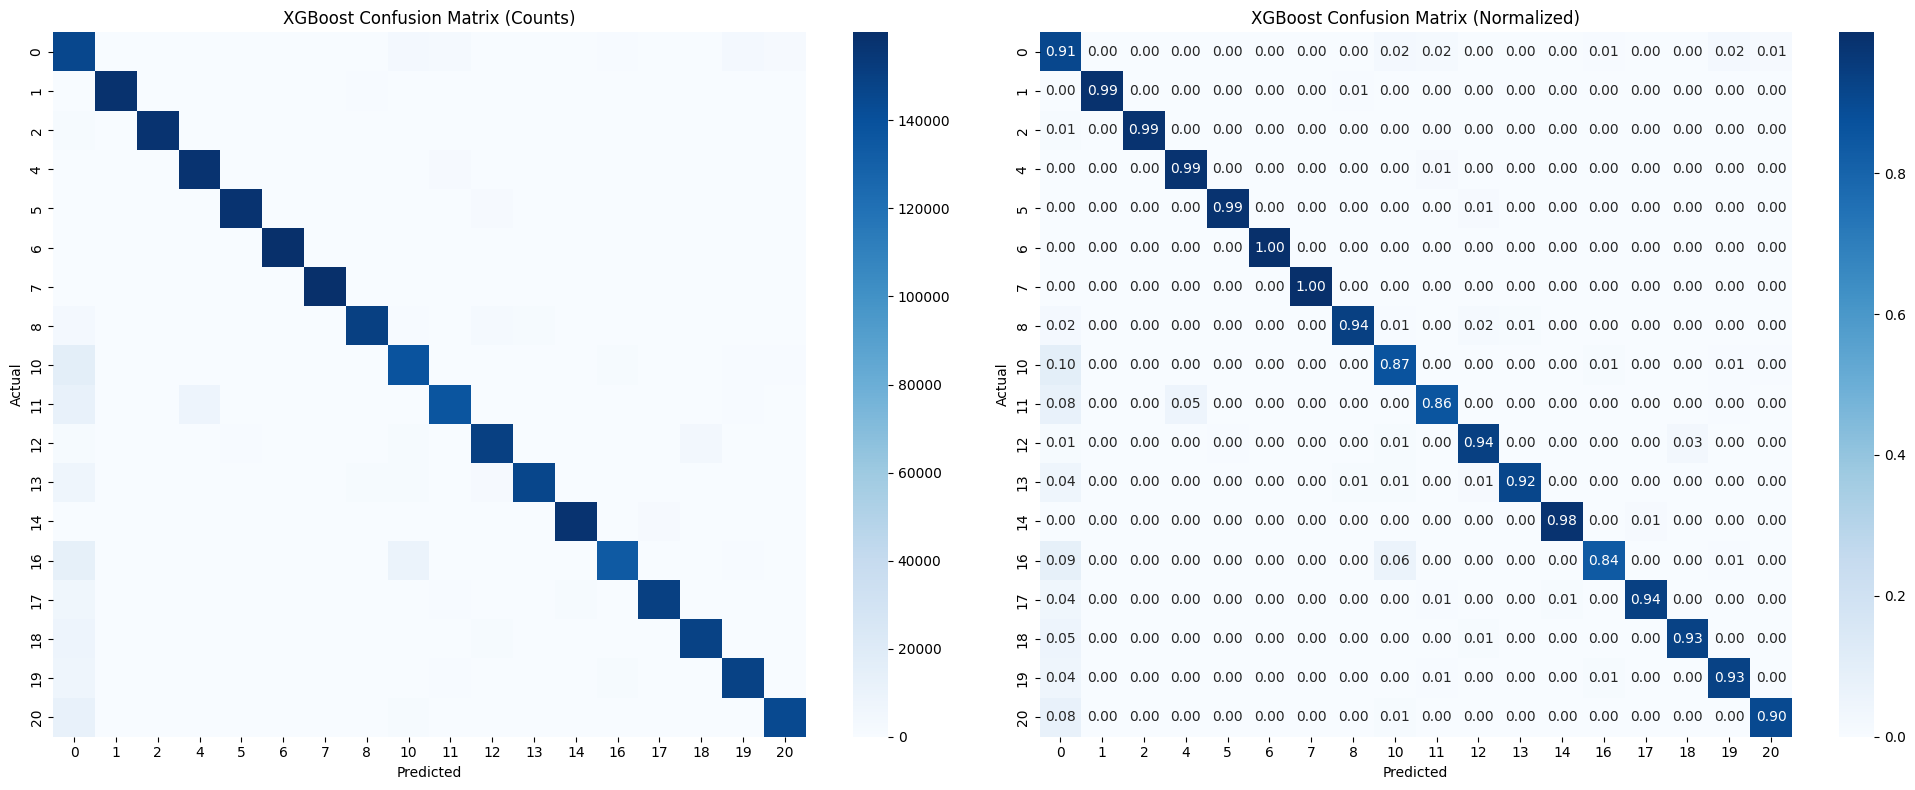

✓ Saved confusion matrix to ../outputs/figures/xgboost_confusion_matrix.png


In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Raw counts
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(f'XGBoost Confusion Matrix (Counts){" - QUICK" if QUICK_MODE else ""}')

# Normalized (percentages)
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'XGBoost Confusion Matrix (Normalized){" - QUICK" if QUICK_MODE else ""}')

plt.tight_layout()
plt.savefig(FIGURES_DIR / f'xgboost_confusion_matrix{MODE_SUFFIX}.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved confusion matrix to {FIGURES_DIR / f'xgboost_confusion_matrix{MODE_SUFFIX}.png'}")

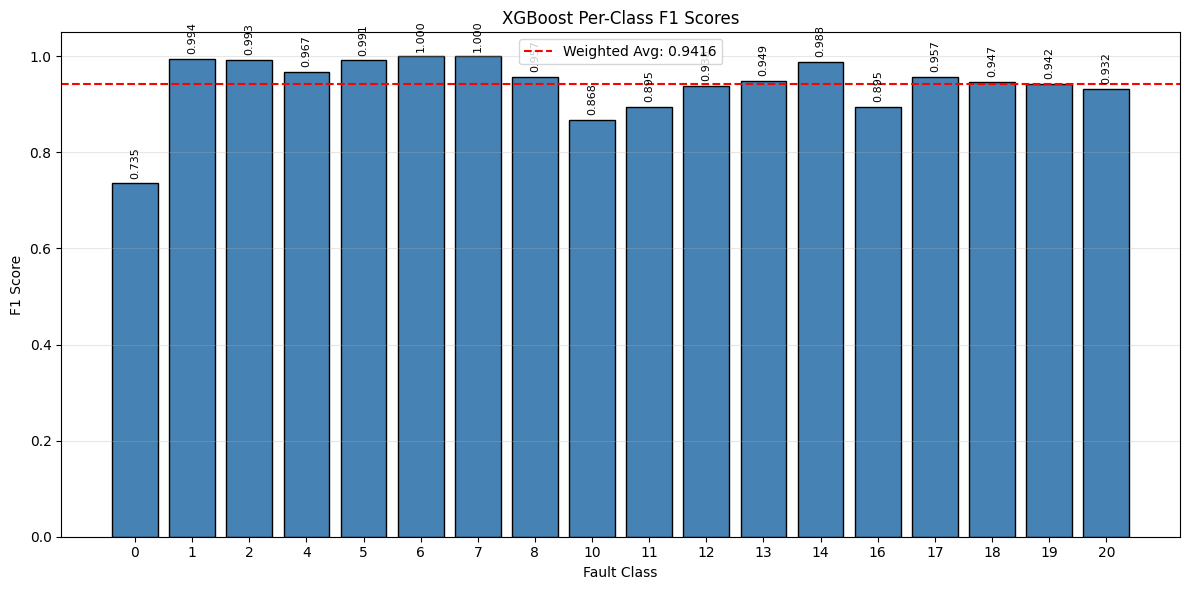

In [9]:
# Per-class F1 scores
f1_per_class = f1_score(y_test, y_pred, average=None)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(class_names, f1_per_class, color='steelblue', edgecolor='black')
ax.axhline(y=f1_weighted, color='red', linestyle='--', label=f'Weighted Avg: {f1_weighted:.4f}')
ax.set_xlabel('Fault Class')
ax.set_ylabel('F1 Score')
ax.set_title(f'XGBoost Per-Class F1 Scores{" - QUICK" if QUICK_MODE else ""}')
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, f1 in zip(bars, f1_per_class):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{f1:.3f}', ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout()
plt.savefig(FIGURES_DIR / f'xgboost_per_class_f1{MODE_SUFFIX}.png', dpi=150, bbox_inches='tight')
plt.show()

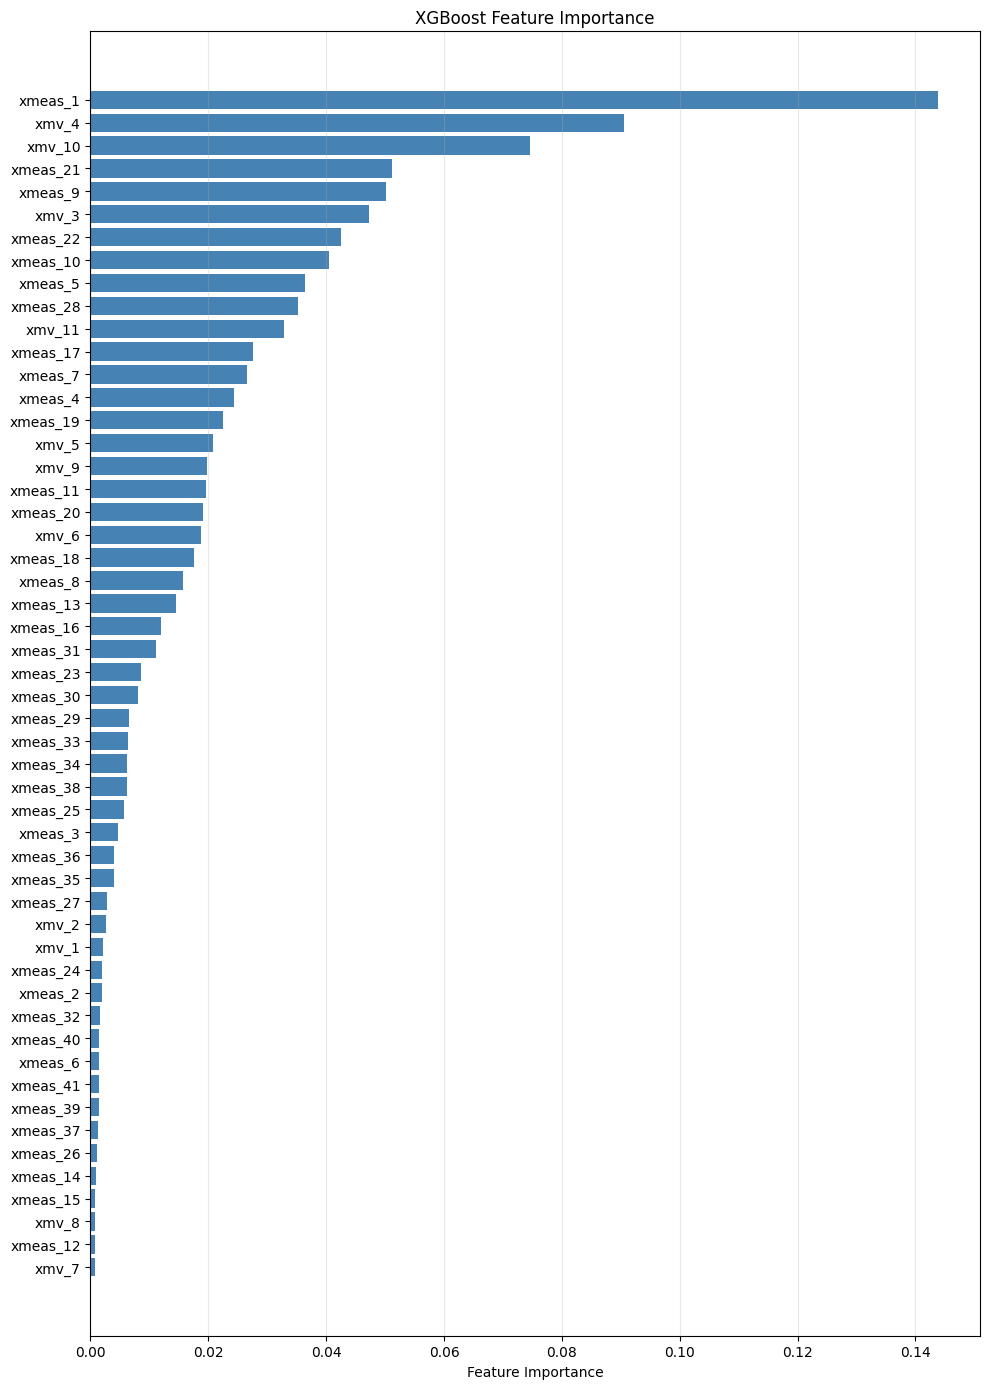


Top 10 Most Important Features:
  xmeas_1: 0.1438
  xmv_4: 0.0905
  xmv_10: 0.0745
  xmeas_21: 0.0511
  xmeas_9: 0.0502
  xmv_3: 0.0473
  xmeas_22: 0.0426
  xmeas_10: 0.0405
  xmeas_5: 0.0363
  xmeas_28: 0.0352


In [10]:
# Feature importance
importance = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': features,
    'importance': importance
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 14))
ax.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
ax.set_xlabel('Feature Importance')
ax.set_title(f'XGBoost Feature Importance{" - QUICK" if QUICK_MODE else ""}')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / f'xgboost_feature_importance{MODE_SUFFIX}.png', dpi=150, bbox_inches='tight')
plt.show()

# Top 10 features
print("\nTop 10 Most Important Features:")
for i, row in importance_df.tail(10).iloc[::-1].iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

## Save Results

In [11]:
end_time = time.time()
total_runtime = end_time - start_time

# Compile all metrics
metrics = {
    'model': 'XGBoost',
    'task': 'multiclass',
    'quick_mode': QUICK_MODE,
    'train_fraction': TRAIN_FRACTION,
    'train_samples': len(y_train),
    'val_samples': len(y_val),
    'test_samples': len(y_test),
    'best_iteration': best_iteration,
    'accuracy': float(accuracy),
    'balanced_accuracy': float(balanced_acc),
    'f1_weighted': float(f1_weighted),
    'f1_macro': float(f1_macro),
    'precision_weighted': float(precision_weighted),
    'recall_weighted': float(recall_weighted),
    'per_class_f1': {class_names[i]: float(f1_per_class[i]) for i in range(num_classes)},
    'hyperparameters': best_params,
    'training_time_seconds': float(train_time),
    'total_runtime_seconds': float(total_runtime),
    'random_seed': RANDOM_SEED
}

# Save metrics
with open(METRICS_DIR / f'xgboost_metrics{MODE_SUFFIX}.json', 'w') as f:
    json.dump(metrics, f, indent=2)
log(f"✓ Saved metrics to {METRICS_DIR / f'xgboost_metrics{MODE_SUFFIX}.json'}")

# Save model
with open(MODEL_DIR / f'xgboost_final{MODE_SUFFIX}.pkl', 'wb') as f:
    pickle.dump({
        'model': model,
        'scaler': scaler,
        'label_encoder': label_encoder,
        'features': features
    }, f)
log(f"✓ Saved model to {MODEL_DIR / f'xgboost_final{MODE_SUFFIX}.pkl'}")

# Save confusion matrix as CSV
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df.to_csv(METRICS_DIR / f'xgboost_confusion_matrix{MODE_SUFFIX}.csv')
log(f"✓ Saved confusion matrix")

log("="*60)
log(f"✓ XGBoost Final Training Complete!")
log(f"Total runtime: {int(total_runtime // 60)}m {int(total_runtime % 60)}s")
log(f"Test Accuracy: {accuracy:.4f}, F1: {f1_weighted:.4f}")
log("="*60)

[2026-01-05 15:03:19] ✓ Saved metrics to ../outputs/metrics/xgboost_metrics.json
[2026-01-05 15:03:19] ✓ Saved model to ../outputs/models/xgboost_final.pkl
[2026-01-05 15:03:19] ✓ Saved confusion matrix
[2026-01-05 15:03:19] ============================================================
[2026-01-05 15:03:19] ✓ XGBoost Final Training Complete!
[2026-01-05 15:03:19] Total runtime: 40m 32s
[2026-01-05 15:03:19] Test Accuracy: 0.9391, F1: 0.9416
[2026-01-05 15:03:19] ============================================================
